## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2025)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset.
    - Extended YaleB dataset.
    - AR dataset (**optional**).
+ Perform Evaluation.
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

## 1. Load Dataset

### 1.0 Data Folder

In [ ]:
# The structure of data folder.
!ls -l data

ls: cannot access 'data': No such file or directory


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import NMF

In [2]:
def load_data(root='data/CroppedYaleB', reduce=3):
    """
    Load ORL (or Extended YaleB) dataset to numpy array.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.

    """
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):

        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):

            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue

            if not fname.endswith('.pgm'):
                continue

            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.
            img = np.asarray(img) / 255.0

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [3]:
# Load ORL dataset.
X, Y = load_data(root='data/ORL', reduce=3)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

# Load Extended YaleB dataset.
X2, Y2 = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X2.shape, Y2.shape))

ORL dataset: X.shape = (1110, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


In [4]:
print(X)
print(Y)

[[0.18431373 0.1254902  0.25882353 ... 0.43921569 0.43921569 0.43921569]
 [0.18823529 0.14117647 0.23137255 ... 0.44313725 0.43921569 0.43921569]
 [0.17254902 0.17647059 0.25882353 ... 0.44705882 0.44313725 0.44313725]
 ...
 [0.16078431 0.13333333 0.12156863 ... 0.34509804 0.3254902  0.34509804]
 [0.17647059 0.1372549  0.12941176 ... 0.34509804 0.3254902  0.3372549 ]
 [0.18039216 0.14901961 0.13333333 ... 0.35686275 0.34117647 0.34509804]]
[ 2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4
  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6
  6  6  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9
  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11
 11 11 11 11 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13
 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16
 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18
 18 18 19 19 19 19 19 19 19 19 19 19 20 20 20

In [5]:
print(X2)
print(Y2)

[[0.3254902  0.36862745 0.31372549 ... 0.01176471 0.01568627 0.01568627]
 [0.36862745 0.41960784 0.4        ... 0.01176471 0.01176471 0.01568627]
 [0.41176471 0.4745098  0.49411765 ... 0.01176471 0.01568627 0.01568627]
 ...
 [0.14117647 0.0745098  0.03137255 ... 0.89019608 0.85490196 0.50980392]
 [0.10196078 0.04313725 0.02352941 ... 0.73333333 0.89411765 0.60784314]
 [0.0627451  0.03137255 0.01960784 ... 0.08627451 0.14117647 0.11764706]]
[ 1  1  1 ... 38 38 38]


### 1.2 Load AR Dataset (Optional)
AR dataset contains 2600 images of 100 individuals (50 male and 50 female). All images have been cropped and resized to 120x165 pixels. To further reduce the computation complexity, you can resize all images to 40x55 pixels.

In [6]:
def load_data_AR(root='data/CroppedAR', reduce=3):
    """
    Load AR dataset to numpy array.

    Args:
        root: path to AR dataset.
        reduce: scale factor for zooming out images.

    """
    #images, labels = [], []
    images = []


    for fname in os.listdir(root):

        if not fname.endswith('.bmp'):
            continue

        # get label.
        #label = int(fname[2:5])
        #if fname[0] == 'W': # start from 50
        #    label += 50

        # load image.
        img = Image.open(os.path.join(root, fname))
        img = img.convert('L') # grey

        # reduce computation complexity.
        img = img.resize([s//reduce for s in img.size])

        # TODO: preprocessing.
        img = np.asarray(img) / 99.0

        # convert image to numpy array.
        img = np.asarray(img).reshape((-1,1))

        # collect data and label.
        images.append(img)
        #labels.append(label)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    #labels = np.array(labels)

    return images, labels

In [ ]:
# X, Y = load_data_AR(root='data/CroppedAR', reduce=3)
# print('AR dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

In [ ]:
data = np.load('data/CroppedAR/ar_database_stacked_128x128.npz')
print(data.files)

['stack']


In [ ]:
X = data['stack']
print(X)
print(X.shape)

X = X.astype(np.float32, copy=False)
mn, mx = float(X.min()), float(X.max())
print("range:", mn, mx)

range: 2.0 99.0


In [ ]:
indices = np.random.choice(X.shape[0], 9, replace=False)

plt.figure(figsize=(8, 8))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i+1)
    plt.imshow(X[idx], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

---------------------------


---------------------------

## 2 Noises

### 2.1 Different add noises functions
+ Pepper and Salt noise

+ Gaussian noise

+ Block occlusion

In [7]:
def add_salt_and_pepper_noise(img, p, s):
    assert 0.0 <= p <= 1.0, "p must be in [0,1]"
    assert 0.0 <= s <= 1.0, "s must be in [0,1]"

    noisy_image = img.copy()

    total = noisy_image.size
    k = int(round(p * total))
    if k == 0:
        return noisy_image

    salt = int(round(s * k))
    pepper = k - salt

    idx = np.random.choice(total, size=k, replace=False)

    flat = noisy_image.reshape(-1)
    if salt > 0:
        flat[idx[:salt]] = 1.0
    if pepper > 0:
        flat[idx[salt:]] = 0.0

    return noisy_image


In [8]:
def add_gaussian_noise(img, sigma=0.10, clip=True):
    """
    sigma: standard deviation of noise, suggested range 0.05~0.20
    """
    noise = np.random.normal(0.0, sigma, size=img.shape).astype(np.float32)
    noisy_image = img.astype(np.float32) + noise
    if clip:
        noisy_image = np.clip(noisy_image, 0.0, 1.0)
    return noisy_image

In [9]:
def add_block_occlusion(img, b=0.20, fill=0.0):
    """
    p: hidden area (0 to 1), 0.2 ≈ 20%
    fill: block color(0.0=black、1.0=white)
    """
    H, W = img.shape[:2]
    A = int(round(b* H * W))
    if A <= 0:
        return img.copy()

    h = max(1, int(round(np.sqrt(A))))
    w = max(1, int(round(A / h)))
    h = min(h, H); w = min(w, W)

    y0 = np.random.randint(0, H - h + 1)
    x0 = np.random.randint(0, W - w + 1)

    noisy_image = img.copy()
    if noisy_image.ndim == 2:
        noisy_image[y0:y0+h, x0:x0+w] = fill
    else:
        noisy_image[y0:y0+h, x0:x0+w, :] = fill
    return noisy_image


### Visualize different noises and compare with original image



#### ORL

In [10]:
def visualize_noise_comparison_orl(root='data/ORL', reduce=2, p= 0.5, s=0.3, sigma=0.1, b=0.1, fill=0, num_images=3):
    """
    Visualize comparison of the first few images before and after adding noise.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        block_size: size of the block noise to be added.
        num_images: number of images to visualize.

    Returns:
        None
    """
    image_counter = 0

    for person in sorted(os.listdir(root)):
        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):
            if not fname.endswith('.pgm') or fname.endswith('Ambient.pgm'):
                continue

            # Load original image
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L')
            img = img.resize([s // reduce for s in img.size])
            img = np.asarray(img) / 255.0


            # Add noise
            noisy_img_salt_and_pepper = add_salt_and_pepper_noise(img, p, s)

            noisy_img_gaussian = add_gaussian_noise(img, sigma)

            noisy_img_block = add_block_occlusion(img, b, fill)

            # Plot original and noisy image
            fig, axs = plt.subplots(1, 4, figsize=(10, 5))
            axs[0].imshow(img, cmap='gray')
            axs[0].set_title('Original')
            axs[0].axis('off')

            axs[1].imshow(noisy_img_salt_and_pepper, cmap='gray')
            axs[1].set_title(f'Salt & Pepper\np={p}, s={s}')
            axs[1].axis('off')


            axs[2].imshow(noisy_img_gaussian, cmap='gray')
            axs[2].set_title(f'Gaussian\nsigma={sigma}')
            axs[2].axis('off')

            axs[3].imshow(noisy_img_block, cmap='gray')
            axs[3].set_title(f'Block Occlusion\nb={b}, fill={fill}')
            axs[3].axis('off')

            plt.show()

            image_counter += 1
            if image_counter >= num_images:
                return

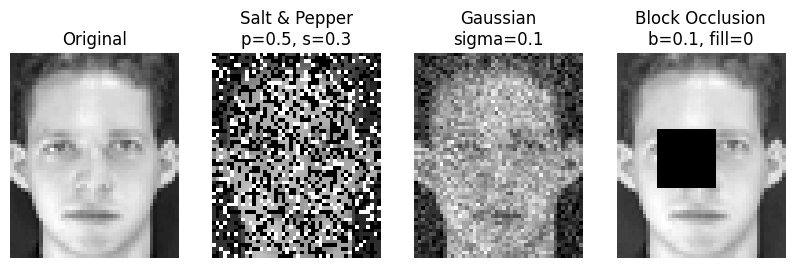

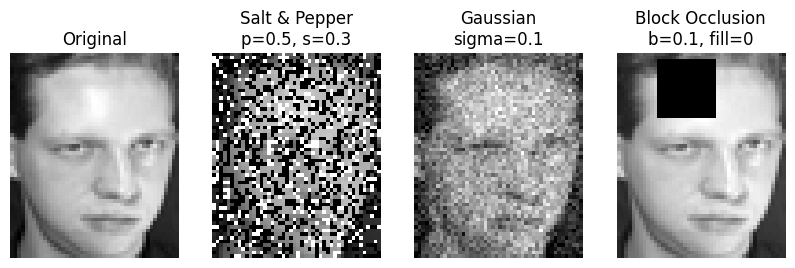

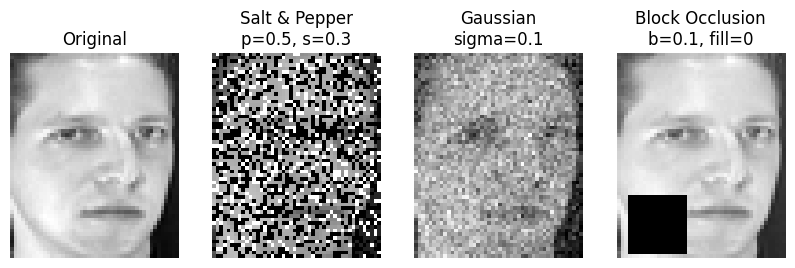

In [11]:
visualize_noise_comparison_orl(root='data/ORL', reduce=2, p= 0.5, s=0.3, sigma=0.1, b=0.1, fill=0, num_images=3)

#### YaleB

In [12]:
def visualize_noise_comparison_YaleB(root='data/CroppedYaleB', reduce=4, p= 0.3, s=0.7, sigma=0.5, b=0.3, fill=1, num_images=3):
    """
    Visualize comparison of the first few images before and after adding noise.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        block_size: size of the block noise to be added.
        num_images: number of images to visualize.

    Returns:
        None
    """
    image_counter = 0

    for person in sorted(os.listdir(root)):
        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):
            if not fname.endswith('.pgm') or fname.endswith('Ambient.pgm'):
                continue

            # Load original image
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L')
            img = img.resize([s // reduce for s in img.size])
            img = np.asarray(img) / 255.0


            # Add noise
            noisy_img_salt_and_pepper = add_salt_and_pepper_noise(img, p, s)

            noisy_img_gaussian = add_gaussian_noise(img, sigma)

            noisy_img_block = add_block_occlusion(img, b, fill)

            # Plot original and noisy image
            fig, axs = plt.subplots(1, 4, figsize=(10, 5))
            axs[0].imshow(img, cmap='gray')
            axs[0].set_title('Original')
            axs[0].axis('off')

            axs[1].imshow(noisy_img_salt_and_pepper, cmap='gray')
            axs[1].set_title(f'Salt & Pepper\np={p}, s={s}')
            axs[1].axis('off')


            axs[2].imshow(noisy_img_gaussian, cmap='gray')
            axs[2].set_title(f'Gaussian\nsigma={sigma}')
            axs[2].axis('off')

            axs[3].imshow(noisy_img_block, cmap='gray')
            axs[3].set_title(f'Block Occlusion\nb={b}, fill={fill}')
            axs[3].axis('off')

            plt.show()

            image_counter += 1
            if image_counter >= num_images:
                return

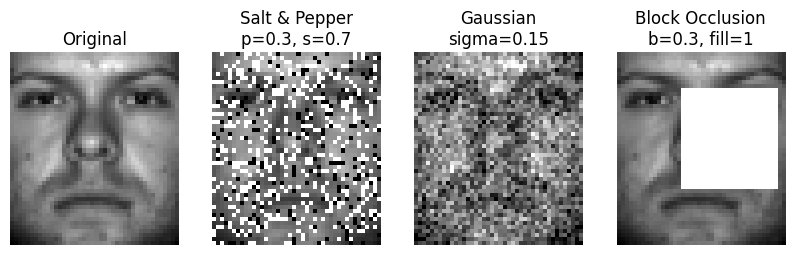

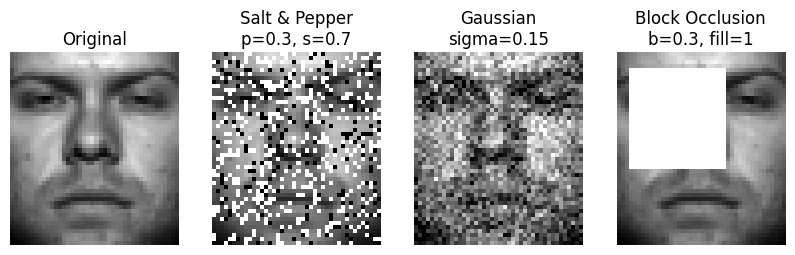

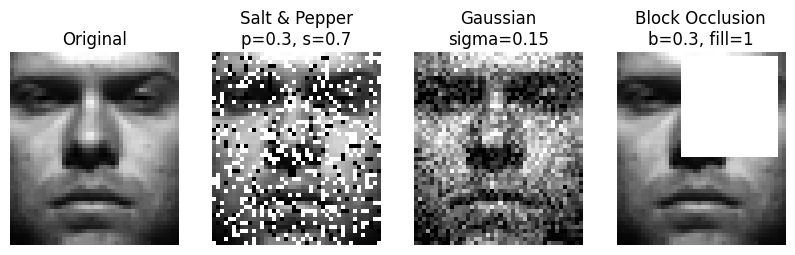

In [13]:
visualize_noise_comparison_YaleB(root='data/CroppedYaleB', reduce=4, p= 0.3, s=0.7, sigma=0.15, b=0.3, fill=1, num_images=3)

---------------------------


## 3. Custom NMF Algorithms


### 3.1 Load data & add noises

In [14]:
# Load dataset.
print('==> Load ORL dataset ...')
X_hat_orl, Y_hat_orl = load_data('data/ORL', reduce=3)
print('X_hat.shape={}, Y_hat.shape={}'.format(X_hat_orl.shape, Y_hat_orl.shape))

print('\n==> Load YaleB dataset ...')
X_hat_yale, Y_hat_yale = load_data('data/CroppedYaleB', reduce=4)
print('X_hat.shape={}, Y_hat.shape={}'.format(X_hat_yale.shape, Y_hat_yale.shape))

==> Load ORL dataset ...
X_hat.shape=(1110, 400), Y_hat.shape=(400,)

==> Load YaleB dataset ...
X_hat.shape=(2016, 2414), Y_hat.shape=(2414,)


In [15]:
def add_noise_to_matrix(X_hat, height, width, noiser):
    D, N = X_hat.shape
    assert D == height * width, f"H*W={height*width} have to equal D={D}"
    X = np.empty_like(X_hat)
    for i in range(N):
        img = X_hat[:, i].reshape(height, width)
        X[:, i] = noiser(img).reshape(-1)
    return X

### 3.2 L2-Norm NMF

In [16]:
def l2_nmf(X, k, max_iter=500, tol=1e-4, eps=1e-8, seed=None):
    rng = np.random.default_rng(seed)
    D_dim, N = X.shape
    D = rng.random((D_dim, k)) + 1e-4
    R = rng.random((k, N)) + 1e-4

    prev = np.inf
    for it in range(max_iter):
        # R ← R ⊙ (DᵀV) / (DᵀDR)
        R *= (D.T @ X) / (D.T @ (D @ R) + eps)

        # D ← D ⊙ (VRᵀ) / (DRRᵀ)
        D *= (X @ R.T) / (D @ (R @ R.T) + eps)

        scale = np.linalg.norm(D, axis=0) + eps
        D /= scale
        R *= scale[:, None]

        # Every 10 iterations check relative decrease
        if it % 10 == 0 or it == max_iter - 1:
            loss = np.linalg.norm(X - D @ R, 'fro')**2
            if not np.isfinite(loss):
                break
            if np.isfinite(prev):
                rel_drop = (prev - loss) / max(prev, 1.0)
                if rel_drop < tol:
                    break
            prev = loss
    return D, R

### 3.3 NMF 2

### 3.4 Hypersurface Cost Based NMF

In [ ]:
def __frobenius_norm(matrix):
    """
    Calculating the frobenius norm of the given matrix.

    Args:
        matrix: a np matrix

    Returns:
        frobenius norm of the matrix
    """
    return np.sqrt(np.sum(np.abs(matrix)**2))

In [ ]:
def rnmf(V, k, max_iter=500, tol=1e-4, eps=1e-8, seed=None, wofle=False):
    rng = np.random.default_rng(seed)
    D, N = V.shape
    W = rng.random((D, k)) + 1e-4
    H = rng.random((k, N)) + 1e-4

    # calculate the cost func ρ in previous iteration
    prev = _cost_function(V, W, H)
    for it in range(max_iter):
        gradient_H = - (W.T @ V + W.T @ W @ H) / (prev+1)
        gradient_W = - (V @ H.T + W @ H @ H.T) / (prev+1)
        alpha = _line_search(prev, V, W, H, gradient_W, 'W', wofle)
        beta = _line_search(prev, V, W, H, gradient_H, 'H', wofle)

        H -= beta * (W.T @ W @ H - W.T @ V) / (prev+1)
        W -= alpha * (W @ H @ H.T - V @ H.T) / (prev+1)

        prev = _cost_function(V, W, H)

        # Every 10 iterations check relative decrease
        if it % 10 == 0 or it == max_iter - 1:
            cost = prev
            if not np.isfinite(cost):
                break
            if np.isfinite(prev):
                rel_drop = (prev - cost) / max(prev, 1.0)
                if rel_drop < tol:
                    break
            prev = cost
    return W, H

In [ ]:
def _cost_function(V, W, H):
    """
    Value of hypersurface cost function, which is the objective function of the RNMF algorithm.
    """
    return np.sqrt(1+__frobenius_norm(V - W @ H)**2) - 1

In [ ]:
def _line_search(f_x, V, W, H, gradient, param, wofle):
    """
    Backtracking line search for determining the step sizes for optimizing W and H using Armijo Condition (and Wofle Condition if the wofle is True).

    Args:
        f_x: value of cost function
        V, W, H: TODO
        gradient: TODO
        param: char, indicator of which parameter to be updated (W or H)
        wofle: boolean, indicator of whether we need to meet Wofle condition in each iteration.

    Returns:
        step: step size.
    """
    step0 = 1.0
    c = 1e-4
    max_iter = 50
    min_step = 1e-16
    tau = 0.5
    t = c * __frobenius_norm(gradient)**2 # assume p is the opposite direction of the gradient
    step = step0
    assert param == 'W' or param == 'H'
    for _ in range(max_iter):
        if step <= min_step:
          return min_step
        new_f_x = 0
        if param == 'W':
          new_f_x = _cost_function(V, W-step*gradient, H)
        elif param == 'H':
          new_f_x = _cost_function(V, W, H-step*gradient)
        if (f_x - new_f_x) < step * t:
          step *= tau
        else:
          return step

## 4. Evaluation Metrics


### 4.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:

 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


In [17]:
def run_and_plot_dataset(ds_name, X_hat, Y_hat, Hh, Ww,
                         p, s, sigma, b, fill,
                         repeats=5, show_index=2):

    k = len(np.unique(Y_hat))

    # add noises
    noiser_pepper   = lambda img: add_salt_and_pepper_noise(img, p, s)
    noiser_gaussian = lambda img: add_gaussian_noise(img, sigma)
    noiser_block    = lambda img: add_block_occlusion(img, b, fill)

    RRE_p, ACC_p, NMI_p, img_p, D_shape, R_shape = eval_one_noise(
        X_hat, Y_hat, Hh, Ww, noiser_pepper,   k, repeats, show_index)
    RRE_g, ACC_g, NMI_g, img_g, _, _ = eval_one_noise(
        X_hat, Y_hat, Hh, Ww, noiser_gaussian, k, repeats, show_index)
    RRE_b, ACC_b, NMI_b, img_b, _, _ = eval_one_noise(
        X_hat, Y_hat, Hh, Ww, noiser_block,    k, repeats, show_index)

    # draw images compare
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    axes[0].imshow(X_hat[:, show_index].reshape(Hh, Ww), cmap='gray'); axes[0].set_title('Original'); axes[0].axis('off')
    axes[1].imshow(img_p, cmap='gray'); axes[1].set_title(f'S&P\np={p:.2f}, s={s:.2f}'); axes[1].axis('off')
    axes[2].imshow(img_g, cmap='gray'); axes[2].set_title(f'Gaussian\nσ={sigma:.2f}');     axes[2].axis('off')
    axes[3].imshow(img_b, cmap='gray'); axes[3].set_title(f'Block\np={b:.2f}, fill={fill:.1f}'); axes[3].axis('off')
    plt.suptitle(ds_name)
    plt.tight_layout(); plt.show()

    # print details
    print("==> Apply NMF ...")
    print(f"D.shape={D_shape}, R.shape={R_shape}")
    print("==> Evaluate RRE ...")
    print(f"pepper  RRE = {np.mean(RRE_p):.6f}")
    print(f"gaussian RRE = {np.mean(RRE_g):.6f}")
    print(f"block    RRE = {np.mean(RRE_b):.6f}")
    print("==> Evaluate Acc and NMI ...")
    print(f"pepper   Acc(NMI) = {np.mean(ACC_p):.4f} ({np.mean(NMI_p):.4f})")
    print(f"gaussian Acc(NMI) = {np.mean(ACC_g):.4f} ({np.mean(NMI_g):.4f})")
    print(f"block    Acc(NMI) = {np.mean(ACC_b):.4f} ({np.mean(NMI_b):.4f})")

    # return outcomes
    return {
        "pepper":   (np.mean(RRE_p), np.mean(ACC_p), np.mean(NMI_p)),
        "gaussian": (np.mean(RRE_g), np.mean(ACC_g), np.mean(NMI_g)),
        "block":    (np.mean(RRE_b), np.mean(ACC_b), np.mean(NMI_b)),
    }


In [ ]:
# # Load dataset.
# print('==> Load ORL dataset ...')
# V_hat, Y_hat = load_data('data/ORL', reduce=3)
# print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

# # Add Noise.
# V_noise = np.random.rand(*V_hat.shape) * 40
# V = V_hat + V_noise

# # Plot result.
# img_size = [i//3 for i in (92, 112)] # ORL
# ind = 2 # index of demo image.
# plt.figure(figsize=(10,3))
# plt.subplot(131)
# plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
# plt.title('Image(Original)')
# plt.subplot(132)
# plt.imshow(V_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
# plt.title('Noise')
# plt.subplot(133)
# plt.imshow(V[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
# plt.title('Image(Noise)')
# plt.show()

# # TODO: you should implement NMF algorithms by yourself.
# print('==> Apply NMF ...')

# model = NMF(n_components=len(set(Y_hat))) # set n_components to num_classes.
# W = model.fit_transform(V)
# H = model.components_
# W_2, H_2 = l2_nmf(V, len(set(Y_hat)))
# # W_3, H_3
# W_4, H_4 = rnmf(V, len(set(Y_hat)))
# print('W_sklearn.shape={}, H_sklearn.shape={}'.format(W.shape, H.shape))
# print('W_l2.shape={}, H_l2.shape={}'.format(W_2.shape, H_2.shape))
# print('W_hsc.shape={}, H_hsc.shape={}'.format(W_4.shape, H_4.shape))

# # Evaluate relative reconstruction errors.
# print('==> Evaluate RRE ...')
# RRE = np.linalg.norm(V_hat - W.dot(H)) / np.linalg.norm(V_hat)
# RRE_2 = np.linalg.norm(V_hat - W_2.dot(H_2)) / np.linalg.norm(V_hat)
# RRE_4 = np.linalg.norm(V_hat - W_4.dot(H_4)) / np.linalg.norm(V_hat)
# print('RRE_sklearn = {}'.format(RRE))
# print('RRE_l2 = {}'.format(RRE_2))
# print('RRE_hsc = {}'.format(RRE_4))

### 3.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [18]:
def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

In [19]:
def eval_one_noise(X_hat, Y_hat, Dd, Rr, noiser, k, repeats=5, show_index=2):

    RREs, ACCs, NMIs = [], [], []
    example_img = None
    R_shape = D_shape = None

    for rep in range(repeats):
        # 1) add noise
        X = add_noise_to_matrix(X_hat, Dd, Rr, noiser)
        example_img = X[:, show_index].reshape(Dd, Rr)

        # 2) L2-NMF
        Rm, Dm = l2_nmf(X, k=k, max_iter=500, tol=1e-4, seed=rep)
        R_shape, D_shape = Rm.shape, Dm.shape

        # 3) RRE
        RRE = np.linalg.norm(X_hat - Rm @ Dm, 'fro') / np.linalg.norm(X_hat, 'fro')
        RREs.append(RRE)

        # 4) clustering metrics
        y_pred_raw = KMeans(n_clusters=k, n_init=10, random_state=rep).fit_predict(Dm.T)
        NMIs.append(normalized_mutual_info_score(Y_hat, y_pred_raw))

        # Acc
        Y_pred_majority = assign_cluster_label(Dm.T, Y_hat)
        ACCs.append(float(np.mean(Y_pred_majority == Y_hat)))

    return RREs, ACCs, NMIs, example_img, R_shape, D_shape


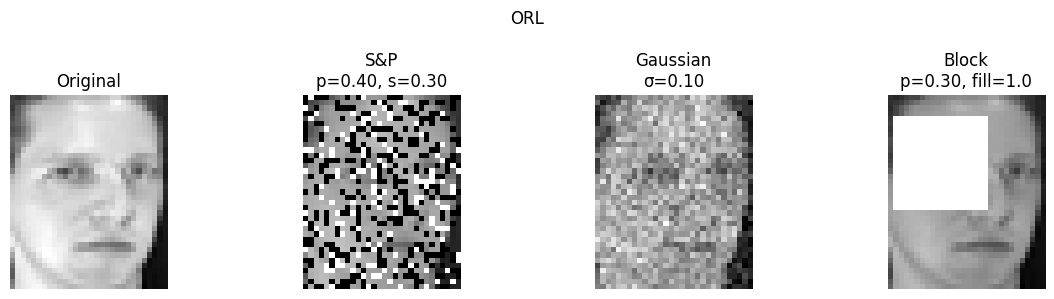

==> Apply NMF ...
D.shape=(1110, 40), R.shape=(40, 400)
==> Evaluate RRE ...
pepper  RRE = 0.347116
gaussian RRE = 0.146261
block    RRE = 0.569269
==> Evaluate Acc and NMI ...
pepper   Acc(NMI) = 0.2545 (0.4799)
gaussian Acc(NMI) = 0.6955 (0.8393)
block    Acc(NMI) = 0.1845 (0.4163)


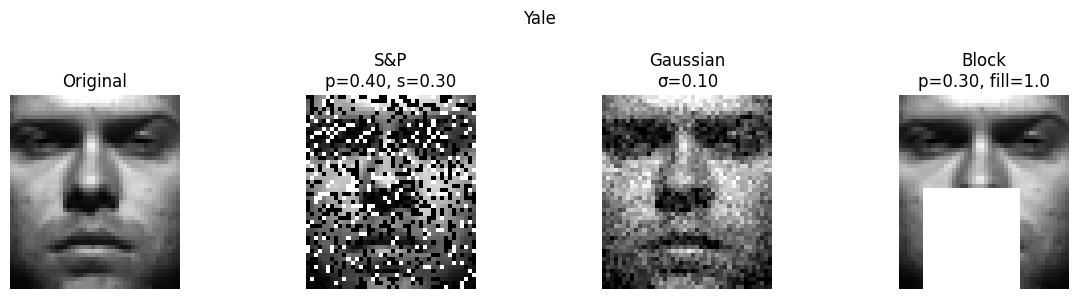

==> Apply NMF ...
D.shape=(2016, 38), R.shape=(38, 2414)
==> Evaluate RRE ...
pepper  RRE = 0.372278
gaussian RRE = 0.196486
block    RRE = 1.107035
==> Evaluate Acc and NMI ...
pepper   Acc(NMI) = 0.1422 (0.2114)
gaussian Acc(NMI) = 0.2069 (0.3259)
block    Acc(NMI) = 0.0805 (0.0957)


In [20]:
D_orl,  R_orl  = 37, 30
D_yale, R_yale = 48, 42

p, s    = 0.4, 0.3
sigma   = 0.10
b, fill = 0.30, 1.0

datasets = {
    "ORL":  (X_hat_orl,  Y_hat_orl,  D_orl,  R_orl),
    "Yale": (X_hat_yale, Y_hat_yale, D_yale, R_yale),
}

all_results = {}
for ds_name, (Xh, Yh, Dd, Rr) in datasets.items():
    all_results[ds_name] = run_and_plot_dataset(
        ds_name, Xh, Yh, Dd, Rr,
        p, s, sigma, b, fill,
        repeats=5, show_index=2
    )


In [ ]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

print('==> Evaluate Acc and NMI ...')

# Assign cluster labels.
Y_pred = assign_cluster_label(H.T, Y_hat)

acc = accuracy_score(Y_hat, Y_pred)
nmi = normalized_mutual_info_score(Y_hat, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))


==> Evaluate Acc and NMI ...
Acc(NMI) = 0.5875 (0.7431)
